# Fitting the Australian Data with LRMoE

## Introduction

In this notebook, we will fit the Australian automobile data `ausprivauto0405` available in the `CASdatasets` [R package](http://cas.uqam.ca/).
We compare the performance of LRMoE mixture of Poisson distributions with the standard Poisson Generalized Linear Model (GLM).

In [1]:
using DrWatson
@quickactivate "LRMoEjl Demo"

using CategoricalArrays, DataFrames, Distributions
using GLM, LRMoE, JLD2, PrettyTables, Random, StatsPlots

# some helper functions are hidden in a separate source file
include(srcdir("2023-CAS-Australian-util.jl"))
using .australian_auto_util_jl:
    load_aus_auto_jld,
    generate_aus_auto_LRMoE_data,
    predict_aus_auto_glm_distribution,
    predict_aus_auto_LRMoE_distribution,
    generate_pmf_comparison,
    plot_pmf_comparison

An overview of the dataset is given below.

In [2]:
df = load_aus_auto_jld()
println("Number of observations: $(nrow(df))")
println("Sample rows of the data:")
pretty_table(first(df, 10))

Number of observations: 67856
Sample rows of the data:


┌──────────┬──────────┬──────────────────────────────────┬──────────────────────────────────┬──────────────────────────────────┬──────────────────────────────────┬──────────┬─────────┬─────────────┐
│ Exposure │ VehValue │                           VehAge │                          VehBody │                           Gender │                          DrivAge │ ClaimOcc │ ClaimNb │ ClaimAmount │
│  Float64 │  Float64 │ CategoricalValue{String, UInt32} │ CategoricalValue{String, UInt32} │ CategoricalValue{String, UInt32} │ CategoricalValue{String, UInt32} │    Int64 │   Int64 │     Float64 │
├──────────┼──────────┼──────────────────────────────────┼──────────────────────────────────┼──────────────────────────────────┼──────────────────────────────────┼──────────┼─────────┼─────────────┤
│ 0.303901 │     1.06 │                         old cars │                        Hatchback │                           Female │                     young people │        0 │       0 │         0.0 │
│ 0.6

In [3]:
println("Distribution of claim frequency:")
df_claim_summary = combine(groupby(df, :ClaimNb),
    :ClaimNb => length => :ClaimNb_Count)
df_claim_summary.ClaimNb_Freq = df_claim_summary.ClaimNb_Count ./ sum(df_claim_summary.ClaimNb_Count)
pretty_table(df_claim_summary)

Distribution of claim frequency:


┌─────────┬───────────────┬──────────────┐
│ ClaimNb │ ClaimNb_Count │ ClaimNb_Freq │
│   Int64 │         Int64 │      Float64 │
├─────────┼───────────────┼──────────────┤
│       0 │         63232 │     0.931856 │
│       1 │          4333 │    0.0638558 │
│       2 │           271 │   0.00399375 │
│       3 │            18 │  0.000265268 │
│       4 │             2 │   2.94742e-5 │
└─────────┴───────────────┴──────────────┘


## Benchmark: Poisson GLM

We consider the Poisson GLM with the following covariates: `Gender`, `DrivAge`, `VehAge` and `VehValue`, with
the logarithm of `Exposure` also incorporated to predict the claim frequency `ClaimNb`. 

In [4]:
fml_ClaimNb = @formula(ClaimNb ~  Gender + DrivAge + VehAge + VehValue)
glm_model = glm(fml_ClaimNb, df, Poisson(), LogLink(); offset=log.(df.Exposure))

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Poisson{Float64}, LogLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

ClaimNb ~ 1 + Gender + DrivAge + VehAge + VehValue

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────────
                                  Coef.  Std. Error       z  Pr(>|z|)    Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                  -1.64426     0.0642326  -25.60    <1e-99  -1.77015     -1.51837
Gender: Male                 -0.0283076   0.0292479   -0.97    0.3331  -0.0856325    0.0290172
DrivAge: young people        -0.164961    0.0539289   -3.06    0.0022  -0.27066     -0.0592621
DrivAge: working people      -0.220313    0.0524707   -4.20    <1e-04  -0.323154    -0.117473
DrivAge: older work. people  -0.247616  

In [5]:
println("Fitted Loglikelihood: $(GLM.loglikelihood(glm_model))")
println("AIC: $(GLM.aic(glm_model))")
println("BIC: $(GLM.bic(glm_model))")

Fitted Loglikelihood: -17408.208623973795
AIC: 34838.41724794759
BIC: 34938.793821956446


## LRMoE with Poisson Experts

We also consider fitting a 3-component LRMoE mixture of Poisson distributions with the same covariates as above.
The first step is to convert the original dataframe into matrix formats
(support for the `@formula` interface is a feature under development).

In [6]:
# convert data to matrix format for model fitting
y, X, y_col, X_col = generate_aus_auto_LRMoE_data(fml_ClaimNb, df)
exposure = df.Exposure
# view the converted data
println("First row of y: $(y[1, :])")
println("First row of X: $(X[1, :])")
println("Column names of X: $(X_col)")

First row of y: [0]


First row of X: [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.06]
Column names of X: ["Gender: Male", "DrivAge: young people", "DrivAge: working people", "DrivAge: older work. people", "DrivAge: old people", "DrivAge: oldest people", "VehAge: young cars", "VehAge: old cars", "VehAge: oldest cars", "VehValue"]


The `LRMoE.jl` package provides a function for initializing a model, which provides initial
values `α_init` for the logit regression parameters and `params_init` for all possible expert functions.
We can pick out the Poisson initializations.

In [7]:
# Random.seed!(20230315)
Random.seed!(42)
n_comp = 3
model_init = cmm_init(y, X, n_comp, ["discrete"]; exact_Y = true, n_random = 0)

(zero_y = [[0.926099348534202 0.931805546976342 0.9433547416536481]], mean_y_pos = [[1.0680834317197954 1.0733695652173914 1.0602655771195098]], var_y_pos = [[0.07449667965058086 0.07530105640742642 0.06896148358890482]], skewness_y_pos = [[4.3293244138414595 3.7874055976659426 5.0045805140080555]], kurtosis_y_pos = [[21.04419431723054 14.437992146863753 30.60971639902842]], α_init = [-0.7532593406407858 0.0 … 0.0 0.0; -0.6878679804817988 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], params_init = Vector{Vector{AnyExpert{LRMoE.NonNegative, z, Distribution{Univariate, Discrete}} where z<:ZeroInflation}}[[[PoissonExpert{Float64}(0.0789320614239181), NegativeBinomialExpert{Float64}(1.3400411565516155, 0.9443738187416029), BinomialExpert{Float64}(6, 0.013155343570653018), GammaCountExpert{Float64}(0.07454137226805231, 1.0589027143218774), ZIPoissonExpert{Float64}(0.4273429111279577, 0.13783477574579564), ZINegativeBinomialExpert{Float64}(0.5, 1.0, 0.5), ZIBinomialExpert{Float64}(0.5227857592732981, 6

In [8]:
# pickout desired parameter initializations
α_init = model_init.α_init
experts_init = vcat([hcat([model_init.params_init[1][j][1] for j in 1:n_comp]...) for d in 1:1]...)
# view
println("α_init: $(α_init)")
println("experts_init: $(experts_init[1, :])")

α_init: [-0.7532593406407858 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -0.6878679804817988 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
experts_init: PoissonExpert{Float64}[PoissonExpert{Float64}(0.0789320614239181), PoissonExpert{Float64}(0.07319785039224165), PoissonExpert{Float64}(0.06005901753167853)]


The model initialization provided by the default function typically performs well.
Sometimes, we may also want to provide our own initializations given some domain knowledge and prior beliefs.
For example, if we believe the portfolio consists of high-, mid- and low-risk subgroups, the experts can be initialized as follows.

In [9]:
experts_init_customized = [PoissonExpert(0.30);; PoissonExpert(0.10);; PoissonExpert(0.05)]

1×3 Matrix{PoissonExpert{Float64}}:
 PoissonExpert{Float64}(0.3)  …  PoissonExpert{Float64}(0.05)

There are several settings to control the fitting function. For example, `ϵ` controls when to stop the EM algorithm based on the increment in loglikelihood, while `ecm_iter_max` provides a hard stop after a certain number of iterations. More details can be found in the package [documentation](https://actsci.utstat.utoronto.ca/LRMoE.jl/stable/fit/).

In [10]:
LRMoE_model = fit_LRMoE(y, X, α_init, experts_init_customized;
    exposure=exposure, exact_Y=true, ϵ=0.01, ecm_iter_max=1000)

┌ Info: Initial loglik: -17497.226255201385 (no penalty), -17504.698826368676 (with penalty)
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:50


┌ Info: Iteration 1, updating α: -17504.698826368676 ->  -17497.208817829134, ( + 0.042788559882328596 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 1, updating model[1, 1]: -17497.208817829134 ->  -17474.800073991995, ( + 0.12807039151470295 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 1, updating model[1, 2]: -17474.800073991995 ->  -17470.23967142192, ( + 0.026097022860143558 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 1, updating model[1, 3]: -17470.23967142192 ->  -17465.46848416373, ( + 0.027310370938953037 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 2, updating α: -17465.46848416373 ->  -17460.61502265782, ( + 0.02778889962391445 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 2, updating model[1, 1]: -17460.61502265782 ->  -17460.598371706157, ( + 9.53629161532863e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 2, updating model[1, 2]: -17460.598371706157 ->  -17460.59353911884, ( + 2.7677100261820465e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 2, updating model[1, 3]: -17460.59353911884 ->  -17459.941889111622, ( + 0.0037321183026085515 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 3, updating α: -17459.941889111622 ->  -17455.57290778243, ( + 0.025022885854606616 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 3, updating model[1, 1]: -17455.57290778243 ->  -17455.550512414095, ( + 0.00012829924547716164 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 3, updating model[1, 2]: -17455.550512414095 ->  -17455.55383987678, ( - 1.9062490647827104e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.11232183645979196 ->  0.11201123078346835
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 3, updating model[1, 3]: -17455.55383987678 ->  -17455.11201770066, ( + 0.00253112665557219 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 4, updating α: -17455.11201770066 ->  -17451.14541414375, ( + 0.02272459525259665 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 4, updating model[1, 1]: -17451.14541414375 ->  -17451.138112878925, ( + 4.183831290852531e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 4, updating model[1, 2]: -17451.138112878925 ->  -17451.134038486223, ( + 2.3347432560952198e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 4, updating model[1, 3]: -17451.134038486223 ->  -17450.812725479256, ( + 0.0018412156267809763 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 5, updating α: -17450.812725479256 ->  -17447.185423109706, ( + 0.02078586497151633 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 5, updating model[1, 1]: -17447.185423109706 ->  -17447.185656529553, ( - 1.3378653427635991e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3290829652077607 ->  0.32835916541722393
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 5, updating model[1, 2]: -17447.185656529553 ->  -17447.170610269382, ( + 8.62388952963427e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 5, updating model[1, 3]: -17447.170610269382 ->  -17446.937863378433, ( + 0.0013340093711973523 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 6, updating α: -17446.937863378433 ->  -17443.601246192924, ( + 0.01912437134605897 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 6, updating model[1, 1]: -17443.601246192924 ->  -17443.60364834596, ( - 1.377096967080913e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.32835916541722393 ->  0.32796970644891077
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 6, updating model[1, 2]: -17443.60364834596 ->  -17443.57642319312, ( + 0.00015607527773071607 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 6, updating model[1, 3]: -17443.57642319312 ->  -17443.40897797511, ( + 0.0009599248110017928 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 7, updating α: -17443.40897797511 ->  -17440.32518430467, ( + 0.017678847490941656 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 7, updating model[1, 1]: -17440.32518430467 ->  -17440.326361967393, ( - 6.752527313321415e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.32796970644891077 ->  0.32786351043616113
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 7, updating model[1, 2]: -17440.326361967393 ->  -17440.28721605909, ( + 0.0002244562830502682 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 7, updating model[1, 3]: -17440.28721605909 ->  -17440.16771475339, ( + 0.0006852026243602164 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 8, updating α: -17440.16771475339 ->  -17437.30695825156, ( + 0.01640326256385857 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 8, updating model[1, 1]: -17437.30695825156 ->  -17437.304953199528, ( + 1.1498633574975376e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 8, updating model[1, 2]: -17437.304953199528 ->  -17437.255039903677, ( + 0.0002862443249357504 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 8, updating model[1, 3]: -17437.255039903677 ->  -17437.17053133018, ( + 0.00048464378885769996 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 9, updating α: -17437.17053133018 ->  -17434.509141932158, ( + 0.015262736538816811 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 9, updating model[1, 1]: -17434.509141932158 ->  -17434.503020930675, ( + 3.5108539236720045e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 9, updating model[1, 2]: -17434.503020930675 ->  -17434.444009897044, ( + 0.00033847270300635087 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 9, updating model[1, 3]: -17434.444009897044 ->  -17434.38485326901, ( + 0.00033930894498821807 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 10, updating α: -17434.38485326901 ->  -17431.90381976141, ( + 0.014230691409423195 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 10, updating model[1, 1]: -17431.90381976141 ->  -17431.893363429735, ( + 5.998387658983448e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 10, updating model[1, 2]: -17431.893363429735 ->  -17431.827183650552, ( + 0.0003796476825771741 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 10, updating model[1, 3]: -17431.827183650552 ->  -17431.786233269682, ( + 0.0002349173178358773 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 11, updating α: -17431.786233269682 ->  -17429.47010217255, ( + 0.013286825951967769 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 11, updating model[1, 1]: -17429.47010217255 ->  -17429.455568476365, ( + 8.338576042765417e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 11, updating model[1, 2]: -17429.455568476365 ->  -17429.384231007865, ( + 0.0004092925807112218 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 11, updating model[1, 3]: -17429.384231007865 ->  -17429.356223860163, ( + 0.00016068925517696375 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 12, updating α: -17429.356223860163 ->  -17427.19225717978, ( + 0.012415643197536769 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 12, updating model[1, 1]: -17427.19225717978 ->  -17427.174202211838, ( + 0.00010360227669578277 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 12, updating model[1, 2]: -17427.174202211838 ->  -17427.0996767803, ( + 0.0004276392183397214 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 12, updating model[1, 3]: -17427.0996767803 ->  -17427.08076861318, ( + 0.00010849864561717561 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 13, updating α: -17427.08076861318 ->  -17425.058293816404, ( + 0.011605356190345759 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 13, updating model[1, 1]: -17425.058293816404 ->  -17425.037437305866, ( + 0.00011969262992927857 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Iteration 13, updating model[1, 2]: -17425.037437305866 ->  -17424.961566930157, ( + 0.00043541011594481414 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 13, updating model[1, 3]: -17424.961566930157 ->  -17424.94897847322, ( + 7.224381463820258e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 14, updating α: -17424.94897847322 ->  -17423.058884374495, ( + 0.010847056717703961 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 14, updating model[1, 1]: -17423.058884374495 ->  -17423.03601057602, ( + 0.00013128463048888532 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 14, updating model[1, 2]: -17423.03601057602 ->  -17422.960454249027, ( + 0.0004336576412191537 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 14, updating model[1, 3]: -17422.960454249027 ->  -17422.95220028209, ( + 4.737407836073042e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 15, updating α: -17422.95220028209 ->  -17421.18654600064, ( + 0.01013407062793244 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 15, updating model[1, 1]: -17421.18654600064 ->  -17421.162432786638, ( + 0.00013841315538365095 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 15, updating model[1, 2]: -17421.162432786638 ->  -17421.088629713708, ( + 0.0004236403467025809 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 15, updating model[1, 3]: -17421.088629713708 ->  -17421.083311309565, ( + 3.05285407567938e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 16, updating α: -17421.083311309565 ->  -17419.435024423048, ( + 0.009461448849434194 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 16, updating model[1, 1]: -17419.435024423048 ->  -17419.410394880386, ( + 0.00014139116812780903 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 16, updating model[1, 2]: -17419.410394880386 ->  -17419.339545752733, ( + 0.0004067251763790272 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 16, updating model[1, 3]: -17419.339545752733 ->  -17419.336191290935, ( + 1.9257112414295024e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 17, updating α: -17419.336191290935 ->  -17417.798837312603, ( + 0.008825560064113535 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 17, updating model[1, 1]: -17417.798837312603 ->  -17417.774329177806, ( + 0.0001407074167381689 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 17, updating model[1, 2]: -17417.774329177806 ->  -17417.707391063486, ( + 0.00038430922949581146 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 17, updating model[1, 3]: -17417.707391063486 ->  -17417.705335267317, ( + 1.1802909089606983e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 18, updating α: -17417.705335267317 ->  -17416.272944619486, ( + 0.008223762087253238 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 18, updating model[1, 1]: -17416.272944619486 ->  -17416.249093644245, ( + 0.00013694649433606862 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 18, updating model[1, 2]: -17416.249093644245 ->  -17416.1867856876, ( + 0.00035775761076931045 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 18, updating model[1, 3]: -17416.1867856876 ->  -17416.185578491728, ( + 6.9314591559619785e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 19, updating α: -17416.185578491728 ->  -17414.852519917815, ( + 0.007654136251048116 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 19, updating model[1, 1]: -17414.852519917815 ->  -17414.829753852286, ( + 0.0001307278686575269 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 19, updating model[1, 2]: -17414.829753852286 ->  -17414.77257132261, ( + 0.0003283553757565708 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 19, updating model[1, 3]: -17414.77257132261 ->  -17414.771910189633, ( + 3.7963916815399026e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 20, updating α: -17414.771910189633 ->  -17413.532801499266, ( + 0.007115273727135325 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 20, updating model[1, 1]: -17413.532801499266 ->  -17413.511441882416, ( + 0.00012266101941527268 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 20, updating model[1, 2]: -17413.511441882416 ->  -17413.45967634949, ( + 0.0002972722250790277 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 20, updating model[1, 3]: -17413.45967634949 ->  -17413.45935696531, ( + 1.8341224697887448e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 21, updating α: -17413.45935696531 ->  -17412.309005449006, ( + 0.006606105614767938 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 21, updating model[1, 1]: -17412.309005449006 ->  -17412.289274842606, ( + 0.00011331412964209583 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 21, updating model[1, 2]: -17412.289274842606 ->  -17412.24303846374, ( + 0.0002655387705481551 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 21, updating model[1, 3]: -17412.24303846374 ->  -17412.24291972213, ( + 6.819432104349492e-7 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 22, updating α: -17412.24291972213 ->  -17411.176285704798, ( + 0.006125770368880631 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 22, updating model[1, 1]: -17411.176285704798 ->  -17411.15831841868, ( + 0.000103193981984321 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 22, updating model[1, 2]: -17411.15831841868 ->  -17411.117570540195, ( + 0.0002340331282874237 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 22, updating model[1, 3]: -17411.117570540195 ->  -17411.11755048795, ( + 1.1516919822731408e-7 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 23, updating α: -17411.11755048795 ->  -17410.129728440526, ( + 0.005673513170877129 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 23, updating model[1, 1]: -17410.129728440526 ->  -17410.113583176764, ( + 9.273488488589946e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 23, updating model[1, 2]: -17410.113583176764 ->  -17410.078157696742, ( + 0.00020347644403923929 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 23, updating model[1, 3]: -17410.078157696742 ->  -17410.078157725457, ( - 1.649307169346658e-10 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.06756937733366858 ->  0.06756937637270508
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 24, updating α: -17410.078157725457 ->  -17409.164370194147, ( + 0.005248612459011027 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 24, updating model[1, 1]: -17409.164370194147 ->  -17409.15004338583, ( + 8.229463523362039e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 24, updating model[1, 2]: -17409.15004338583 ->  -17409.119675591668, ( + 0.00017443582304250575 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 24, updating model[1, 3]: -17409.119675591668 ->  -17409.11963067438, ( + 2.580101029405393e-7 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 25, updating α: -17409.11963067438 ->  -17408.275231055482, ( + 0.004850329234398592 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 25, updating model[1, 1]: -17408.275231055482 ->  -17408.262669987755, ( + 7.21557280148785e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 25, updating model[1, 2]: -17408.262669987755 ->  -17408.237021859826, ( + 0.00014733307059211812 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 25, updating model[1, 3]: -17408.237021859826 ->  -17408.236875067745, ( + 8.432334697875525e-7 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 26, updating α: -17408.236875067745 ->  -17407.457355967676, ( + 0.004477875075252609 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 26, updating model[1, 1]: -17407.457355967676 ->  -17407.446471040384, ( + 6.253025395069045e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 26, updating model[1, 2]: -17407.446471040384 ->  -17407.42515428767, ( + 0.00012245766632082753 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 26, updating model[1, 3]: -17407.42515428767 ->  -17407.42485419809, ( + 1.7239171136895573e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 27, updating α: -17407.42485419809 ->  -17406.70585877359, ( + 0.004130395107390426 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 27, updating model[1, 1]: -17406.70585877359 ->  -17406.696534494233, ( + 5.3567167913029554e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 27, updating model[1, 2]: -17406.696534494233 ->  -17406.679130844663, ( + 9.998249544681749e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 27, updating model[1, 3]: -17406.679130844663 ->  -17406.67863077376, ( + 2.872867930354951e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 28, updating α: -17406.67863077376 ->  -17406.015965042512, ( + 0.0038069625188379137 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 28, updating model[1, 1]: -17406.015965042512 ->  -17406.008069524527, ( + 4.536085684983212e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 28, updating model[1, 2]: -17406.008069524527 ->  -17405.99414802081, ( + 7.998102529030725e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 28, updating model[1, 3]: -17405.99414802081 ->  -17405.99340628866, ( + 4.261360448806554e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 29, updating α: -17405.99340628866 ->  -17405.383050928252, ( + 0.00350658159038183 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 29, updating model[1, 1]: -17405.383050928252 ->  -17405.376443814894, ( + 3.796017208834732e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 29, updating model[1, 2]: -17405.376443814894 ->  -17405.365575058426, ( + 6.244482274230576e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 29, updating model[1, 3]: -17405.365575058426 ->  -17405.364555721168, ( + 5.856454170925038e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 30, updating α: -17405.364555721168 ->  -17404.80267633007, ( + 0.003228196624662798 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 30, updating model[1, 1]: -17404.80267633007 ->  -17404.797215171682, ( + 3.137730710823191e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 30, updating model[1, 2]: -17404.797215171682 ->  -17404.78898260906, ( + 4.730053742686966e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 30, updating model[1, 3]: -17404.78898260906 ->  -17404.787656277633, ( + 7.620497036175381e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 31, updating α: -17404.787656277633 ->  -17404.27061145335, ( + 0.002970704581368468 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 31, updating model[1, 1]: -17404.27061145335 ->  -17404.26615664049, ( + 2.5596090524208125e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 31, updating model[1, 2]: -17404.26615664049 ->  -17404.260165099462, ( + 3.44257032933489e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 31, updating model[1, 3]: -17404.260165099462 ->  -17404.25850960954, ( + 9.511981016668807e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Iteration 32, updating α: -17404.25850960954 ->  -17403.782856507045, ( + 0.002732969647810512 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 32, updating model[1, 1]: -17403.782856507045 ->  -17403.779274908742, ( + 2.0579424211243255e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Iteration 32, updating model[1, 2]: -17403.779274908742 ->  -17403.775156665593, ( + 2.3662924492688988e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 32, updating model[1, 3]: -17403.775156665593 ->  -17403.77315747301, ( + 1.1487120269922265e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 33, updating α: -17403.77315747301 ->  -17403.335654746163, ( + 0.002513838366476039 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 33, updating model[1, 1]: -17403.335654746163 ->  -17403.332822227603, ( + 1.6275722169798665e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 33, updating model[1, 2]: -17403.332822227603 ->  -17403.330240930638, ( + 1.4832199048225256e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 33, updating model[1, 3]: -17403.330240930638 ->  -17403.327891186127, ( + 1.3501694666114382e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 34, updating α: -17403.327891186127 ->  -17402.925499391422, ( + 0.002312154303022537 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 34, updating model[1, 1]: -17402.925499391422 ->  -17402.923302392956, ( + 1.2624305416150584e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 34, updating model[1, 2]: -17402.923302392956 ->  -17402.921955182857, ( + 7.741286189482632e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 34, updating model[1, 3]: -17402.921955182857 ->  -17402.919255493714, ( + 1.5512849795299708e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 35, updating α: -17402.919255493714 ->  -17402.549135158697, ( + 0.0021267715466793276 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 35, updating model[1, 1]: -17402.549135158697 ->  -17402.547471513637, ( + 9.559777979154647e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 35, updating model[1, 2]: -17402.547471513637 ->  -17402.54708967653, ( + 2.1941449002070887e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 35, updating model[1, 3]: -17402.54708967653 ->  -17402.54404759637, ( + 1.7480660410379888e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 36, updating α: -17402.54404759637 ->  -17402.203555232223, ( + 0.001956566598626213 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 36, updating model[1, 1]: -17402.203555232223 ->  -17402.20233438831, ( + 7.015455892726701e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 36, updating model[1, 2]: -17402.20233438831 ->  -17402.202682857223, ( - 2.002441463095029e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Intended update of params: 0.08982107332030803 ->  0.08960477906438402
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137
┌ Info: Iteration 36, updating model[1, 3]: -17402.202682857223 ->  -17402.199312162767, ( + 1.9369355232674433e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 37, updating α: -17402.199312162767 ->  -17401.885994541655, ( + 0.0018004484116742343 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 37, updating model[1, 1]: -17401.885994541655 ->  -17401.885137332985, ( + 4.9259526822673685e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 37, updating model[1, 2]: -17401.885137332985 ->  -17401.88601332352, ( - 5.033882989957702e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.08960477906438402 ->  0.08941408047754004
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 37, updating model[1, 3]: -17401.88601332352 ->  -17401.882333143567, ( + 2.1148167224097672e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 38, updating α: -17401.882333143567 ->  -17401.593920174037, ( + 0.0016573665078806843 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 38, updating model[1, 1]: -17401.593920174037 ->  -17401.593358270464, ( + 3.2290350837603982e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 38, updating model[1, 2]: -17401.593358270464 ->  -17401.594589300537, ( - 7.074237675802708e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.08941408047754004 ->  0.08924730794139096
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 38, updating model[1, 3]: -17401.594589300537 ->  -17401.59062316049, ( + 2.279181960881555e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 39, updating α: -17401.59062316049 ->  -17401.32501968669, ( + 0.0015263172174948855 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 39, updating model[1, 1]: -17401.32501968669 ->  -17401.324694826522, ( + 1.8668702959448392e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Iteration 39, updating model[1, 2]: -17401.324694826522 ->  -17401.326136332184, ( - 8.283884626517662e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Intended update of params: 0.08924730794139096 ->  0.08910284115182948
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 39, updating model[1, 3]: -17401.326136332184 ->  -17401.32191117089, ( + 2.428068562656604e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 40, updating α: -17401.32191117089 ->  -17401.07718799936, ( + 0.0014063481658447658 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 40, updating model[1, 1]: -17401.07718799936 ->  -17401.077051091608, ( + 7.867774470392038e-7 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 40, updating model[1, 2]: -17401.077051091608 ->  -17401.078583813345, ( - 8.808200391970544e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.08910284115182948 ->  0.08897911733304066
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 40, updating model[1, 3]: -17401.078583813345 ->  -17401.07412901938, ( + 2.5600677243465354e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 41, updating α: -17401.07412901938 ->  -17400.84851344656, ( + 0.0012965611843737653 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 41, updating model[1, 1]: -17400.84851344656 ->  -17400.8485236104, ( - 5.8410023816256974e-8 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.34540982462954706 ->  0.3454079497793075
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 41, updating model[1, 2]: -17400.8485236104 ->  -17400.850050888934, ( - 8.77703482591796e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.08897911733304066 ->  0.08887463739158817
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 41, updating model[1, 3]: -17400.850050888934 ->  -17400.84539739302, ( + 2.6742922909351717e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 42, updating α: -17400.84539739302 ->  -17400.63726347136, ( + 0.001196113849108586 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 42, updating model[1, 1]: -17400.63726347136 ->  -17400.637387064326, ( - 7.102783928568549e-7 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3454079497793075 ->  0.34538320524194666
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 42, updating model[1, 2]: -17400.637387064326 ->  -17400.638832152945, ( - 8.304802790126822e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.08887463739158817 ->  0.08878797028317376
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 42, updating model[1, 3]: -17400.638832152945 ->  -17400.634011602797, ( + 2.770329408302848e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 43, updating α: -17400.634011602797 ->  -17400.44187034633, ( + 0.0011042198596787288 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 43, updating model[1, 1]: -17400.44187034633 ->  -17400.442080018976, ( - 1.2049846049095742e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.34538320524194666 ->  0.34533772954483555
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 43, updating model[1, 2]: -17400.442080018976 ->  -17400.44338349151, ( - 7.491031137896854e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.08878797028317376 ->  0.08871775584579883
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 43, updating model[1, 3]: -17400.44338349151 ->  -17400.438427525918, ( + 2.8481835108715325e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 44, updating α: -17400.438427525918 ->  -17400.260917220232, ( + 0.001020148465945261 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 44, updating model[1, 1]: -17400.260917220232 ->  -17400.26119102325, ( - 1.5735569777454773e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.34533772954483555 ->  0.34527355203396615
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 44, updating model[1, 2]: -17400.26119102325 ->  -17400.26230833307, ( - 6.421224400483311e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.08871775584579883 ->  0.08866270633236419
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 44, updating model[1, 3]: -17400.26230833307 ->  -17400.257247963877, ( + 2.9082143147248717e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 45, updating α: -17400.257247963877 ->  -17400.09312471145, ( + 0.0009432231379584587 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 45, updating model[1, 1]: -17400.09312471145 ->  -17400.093445272098, ( - 1.8422927153808235e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.34527355203396615 ->  0.3451925882249591
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 45, updating model[1, 2]: -17400.093445272098 ->  -17400.09434449791, ( - 5.167936681284288e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.08866270633236419 ->  0.08862160685418774
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 45, updating model[1, 3]: -17400.09434449791 ->  -17400.08920960182, ( + 2.951073704644755e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 46, updating α: -17400.08920960182 ->  -17399.93733820331, ( + 0.0008728196544295716 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 46, updating model[1, 1]: -17399.93733820331 ->  -17399.93769198045, ( - 2.0332092600694673e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3451925882249591 ->  0.345096637435158
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 46, updating model[1, 2]: -17399.93769198045 ->  -17399.93835177911, ( - 3.7919599075454738e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Intended update of params: 0.08862160685418774 ->  0.08859331492525446
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137
┌ Info: Iteration 46, updating model[1, 3]: -17399.93835177911 ->  -17399.93317069629, ( + 2.9776443538409167e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 47, updating α: -17399.93317069629 ->  -17399.792515941157, ( + 0.0008083637664255237 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 47, updating model[1, 1]: -17399.792515941157 ->  -17399.79289256273, ( - 2.164517615713981e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Intended update of params: 0.345096637435158 ->  0.34498738230986403
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137
┌ Info: Iteration 47, updating model[1, 2]: -17399.79289256273 ->  -17399.793300336973, ( - 2.3435580181005346e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.08859331492525446 ->  0.08857675927582119
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 47, updating model[1, 3]: -17399.793300336973 ->  -17399.788099569552, ( + 2.9889823002776055e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 48, updating α: -17399.788099569552 ->  -17399.657717986658, ( + 0.0007493285673830324 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 48, updating model[1, 1]: -17399.657717986658 ->  -17399.658109669243, ( - 2.25109361803701e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.34498738230986403 ->  0.3448663898979994
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 48, updating model[1, 2]: -17399.658109669243 ->  -17399.658259949116, ( - 8.636944027811429e-7 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.08857675927582119 ->  0.08857093808371004
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 48, updating model[1, 3]: -17399.658259949116 ->  -17399.65306395028, ( + 2.9862648774298525e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 49, updating α: -17399.65306395028 ->  -17399.5320960496, ( + 0.00069523168213666 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 49, updating model[1, 1]: -17399.5320960496 ->  -17399.5324970967, ( - 2.304930384595179e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3448663898979994 ->  0.3447351139731406
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 49, updating model[1, 2]: -17399.5324970967 ->  -17399.532390126955, ( + 6.147851755765685e-7 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 49, updating model[1, 3]: -17399.532390126955 ->  -17399.527221169934, ( + 2.970744790747893e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 50, updating α: -17399.527221169934 ->  -17399.414884190755, ( + 0.0006456323654692646 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 50, updating model[1, 1]: -17399.414884190755 ->  -17399.415290564717, ( - 2.3355610766259328e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3447351139731406 ->  0.344594898334306
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 50, updating model[1, 2]: -17399.415290564717 ->  -17399.414931085772, ( + 2.066040375643571e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 50, updating model[1, 3]: -17399.414931085772 ->  -17399.409809201312, ( + 2.9437107399195155e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 51, updating α: -17399.409809201312 ->  -17399.305390369696, ( + 0.0006001285834434237 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 51, updating model[1, 1]: -17399.305390369696 ->  -17399.305799330803, ( - 2.3504450172640677e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.344594898334306 ->  0.344446980856656
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 51, updating model[1, 2]: -17399.305799330803 ->  -17399.305195538225, ( + 3.4702107354900373e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 51, updating model[1, 3]: -17399.305195538225 ->  -17399.300138509327, ( + 2.9064545059464426e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 52, updating α: -17399.300138509327 ->  -17399.20298879782, ( + 0.0005583541334001386 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 52, updating model[1, 1]: -17399.20298879782 ->  -17399.20339860366, ( - 2.3553138511769673e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Intended update of params: 0.344446980856656 ->  0.3442924980951336
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137
┌ Info: Iteration 52, updating model[1, 2]: -17399.20339860366 ->  -17399.20256126942, ( + 4.8124860645182244e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 52, updating model[1, 3]: -17399.20256126942 ->  -17399.197584672547, ( + 2.8602442295353057e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 53, updating α: -17399.197584672547 ->  -17399.107113047532, ( + 0.0005199758470177776 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 53, updating model[1, 1]: -17399.107113047532 ->  -17399.107522705563, ( - 2.35447731821478e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3442924980951336 ->  0.34413249027390164
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 53, updating model[1, 2]: -17399.107522705563 ->  -17399.106464443987, ( + 6.082275051074318e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 53, updating model[1, 3]: -17399.106464443987 ->  -17399.10158172677, ( + 2.8063034315441194e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 54, updating α: -17399.10158172677 ->  -17399.017249863668, ( + 0.00048469090605210245 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 54, updating model[1, 1]: -17399.017249863668 ->  -17399.017658930054, ( - 2.3510890309532086e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.34413249027390164 ->  0.34396790652122683
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 54, updating model[1, 2]: -17399.017658930054 ->  -17399.016393591508, ( + 7.272471184524636e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 54, updating model[1, 3]: -17399.016393591508 ->  -17399.011616177962, ( + 2.7457951860343517e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 55, updating α: -17399.011616177962 ->  -17398.932933620643, ( + 0.0004522242932833736 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 55, updating model[1, 1]: -17398.932933620643 ->  -17398.933342038865, ( - 2.347375114791404e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.34396790652122683 ->  0.3437996102332909
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 55, updating model[1, 2]: -17398.933342038865 ->  -17398.93188421489, ( + 8.378812347611422e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 55, updating model[1, 3]: -17398.93188421489 ->  -17398.927221630405, ( + 2.679810758125967e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 56, updating α: -17398.927221630405 ->  -17398.85374136882, ( + 0.0004223263920144772 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 56, updating model[1, 1]: -17398.85374136882 ->  -17398.854149342016, ( - 2.3448280060054495e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3437996102332909 ->  0.34362838447140964
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 56, updating model[1, 2]: -17398.854149342016 ->  -17398.852513966835, ( + 9.399326918959344e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 56, updating model[1, 3]: -17398.852513966835 ->  -17398.847973976062, ( + 2.609362179792368e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 57, updating α: -17398.847973976062 ->  -17398.77928841489, ( + 0.00039477074156797995 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 57, updating model[1, 1]: -17398.77928841489 ->  -17398.77969630651, ( - 2.344369167820702e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Intended update of params: 0.34362838447140964 ->  0.34345493731548865
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137
┌ Info: Iteration 57, updating model[1, 2]: -17398.77969630651 ->  -17398.777898340904, ( + 1.0333860393880885e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 57, updating model[1, 3]: -17398.777898340904 ->  -17398.77348709305, ( + 2.53537798996141e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 58, updating α: -17398.77348709305 ->  -17398.709224383696, ( + 0.00036935195117333543 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 58, updating model[1, 1]: -17398.709224383696 ->  -17398.70963264167, ( - 2.346484255409153e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.34345493731548865 ->  0.3432799071124412
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 58, updating model[1, 2]: -17398.70963264167 ->  -17398.70768682671, ( + 1.1183673957704512e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 58, updating model[1, 3]: -17398.70768682671 ->  -17398.70340900349, ( + 2.458701701894299e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 59, updating α: -17398.70340900349 ->  -17398.643229712077, ( + 0.00034588377075234645 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 59, updating model[1, 1]: -17398.643229712077 ->  -17398.643638812184, ( - 2.3513333831809037e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3432799071124412 ->  0.3431038675719476
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 59, updating model[1, 2]: -17398.643638812184 ->  -17398.641559481595, ( + 1.195110740597974e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 59, updating model[1, 3]: -17398.641559481595 ->  -17398.637418444287, ( + 2.380092316155961e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 60, updating α: -17398.637418444287 ->  -17398.581012528863, ( + 0.00032419731538384667 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 60, updating model[1, 1]: -17398.581012528863 ->  -17398.581422933774, ( - 2.3588412810225005e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3431038675719476 ->  0.34292733267356906
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 60, updating model[1, 2]: -17398.581422933774 ->  -17398.579223875044, ( + 1.263929901368663e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 60, updating model[1, 3]: -17398.579223875044 ->  -17398.575221807674, ( + 2.300226540389992e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 61, updating α: -17398.575221807674 ->  -17398.522305879033, ( + 0.0003041394365170222 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101
┌ Info: Iteration 61, updating model[1, 1]: -17398.522305879033 ->  -17398.522718009805, ( - 2.368768822858455e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Intended update of params: 0.34292733267356906 ->  0.3427507613590541
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137
┌ Info: Iteration 61, updating model[1, 2]: -17398.522718009805 ->  -17398.520412365546, ( + 1.3251954180878282e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 61, updating model[1, 3]: -17398.520412365546 ->  -17398.51655041212, ( + 2.2197022119209904e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Iteration 62, updating α: -17398.51655041212 ->  -17398.466865253933, ( + 0.0002855712327220828 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 62, updating model[1, 1]: -17398.466865253933 ->  -17398.467279471355, ( - 2.3807696694428815e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3427507613590541 ->  0.3425745619918965
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 62, updating model[1, 2]: -17398.467279471355 ->  -17398.46487967337, ( + 1.3793157441431238e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 62, updating model[1, 3]: -17398.46487967337 ->  -17398.461158067625, ( + 2.1390425948430007e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Iteration 63, updating α: -17398.461158067625 ->  -17398.414466392867, ( + 0.0002683666925086732 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 63, updating model[1, 1]: -17398.414466392867 ->  -17398.414882986508, ( - 2.3944345129733757e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3425745619918965 ->  0.34239909657301243
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 63, updating model[1, 2]: -17398.414882986508 ->  -17398.412400716326, ( + 1.4267220309087238e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 63, updating model[1, 3]: -17398.412400716326 ->  -17398.40881890288, ( + 2.0587013131654687e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 64, updating α: -17398.40881890288 ->  -17398.364903325302, ( + 0.00025241145920615814 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 64, updating model[1, 1]: -17398.364903325302 ->  -17398.36532250837, ( - 2.409324491272985e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.34239909657301243 ->  0.3422246847069895
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 64, updating model[1, 2]: -17398.36532250837 ->  -17398.36276867881, ( + 1.4678560382740944e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 64, updating model[1, 3]: -17398.36276867881 ->  -17398.35932542525, ( + 1.9790675749507656e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 65, updating α: -17398.35932542525 ->  -17398.317986625894, ( + 0.00023760171048754677 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 65, updating model[1, 1]: -17398.317986625894 ->  -17398.318408534462, ( - 2.424996301273942e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3422246847069895 ->  0.3420516073178741
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 65, updating model[1, 2]: -17398.318408534462 ->  -17398.31579328772, ( + 1.5031606400730644e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 65, updating model[1, 3]: -17398.31579328772 ->  -17398.312486787243, ( + 1.9004715828424486e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 66, updating α: -17398.312486787243 ->  -17398.273541857834, ( + 0.00022384314247990943 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 66, updating model[1, 1]: -17398.273541857834 ->  -17398.273966553243, ( - 2.4410204125205982e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Intended update of params: 0.3420516073178741 ->  0.3418801101170673
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137
┌ Info: Iteration 66, updating model[1, 2]: -17398.273966553243 ->  -17398.271299271684, ( + 1.533072512546672e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 66, updating model[1, 3]: -17398.271299271684 ->  -17398.268127236373, ( + 1.823189934385468e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 67, updating α: -17398.268127236373 ->  -17398.231408182644, ( + 0.00021105005084700042 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 67, updating model[1, 1]: -17398.231408182644 ->  -17398.231835656068, ( - 2.456993551474724e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Intended update of params: 0.3418801101170673 ->  0.34171040682871995
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137
┌ Info: Iteration 67, updating model[1, 2]: -17398.231835656068 ->  -17398.229124982685, ( + 1.5580165897704614e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 67, updating model[1, 3]: -17398.229124982685 ->  -17398.226084727532, ( + 1.7474509221842057e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 68, updating α: -17398.226084727532 ->  -17398.191437117155, ( + 0.00019914450018134445 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101
┌ Info: Iteration 68, updating model[1, 1]: -17398.191437117155 ->  -17398.191867295653, ( - 2.472547212945672e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Intended update of params: 0.34171040682871995 ->  0.34154268218017475
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 68, updating model[1, 2]: -17398.191867295653 ->  -17398.189121161464, ( + 1.57840206024222e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 68, updating model[1, 3]: -17398.189121161464 ->  -17398.186209679603, ( + 1.6734395979470194e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 69, updating α: -17398.186209679603 ->  -17398.153491420646, ( + 0.0001880555740860608 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 69, updating model[1, 1]: -17398.153491420646 ->  -17398.15392417403, ( - 2.48735236585248e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.34154268218017475 ->  0.34137709466661303
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 69, updating model[1, 2]: -17398.15392417403 ->  -17398.151149830504, ( + 1.5946194843520922e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 69, updating model[1, 3]: -17398.151149830504 ->  -17398.14836386, ( + 1.6013026212955266e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 70, updating α: -17398.14836386 ->  -17398.117444097137, ( + 0.00017771869865920628 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 70, updating model[1, 1]: -17398.117444097137 ->  -17398.117879245277, ( - 2.5011219842556246e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.34137709466661303 ->  0.3412137791001953
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 70, updating model[1, 2]: -17398.117879245277 ->  -17398.115083299974, ( + 1.6070389470090232e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 70, updating model[1, 3]: -17398.115083299974 ->  -17398.11241938275, ( + 1.531152778306278e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 71, updating α: -17398.11241938275 ->  -17398.083177499662, ( + 0.0001680750324053531 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 71, updating model[1, 1]: -17398.083177499662 ->  -17398.083614819843, ( - 2.513611278174346e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3412137791001953 ->  0.3410528489547508
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 71, updating model[1, 2]: -17398.083614819843 ->  -17398.08080327392, ( + 1.6160089735931554e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 71, updating model[1, 3]: -17398.08080327392 ->  -17398.07825780744, ( + 1.4630731446689583e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 72, updating α: -17398.07825780744 ->  -17398.050582524862, ( + 0.00015907091672684088 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 72, updating model[1, 1]: -17398.050582524862 ->  -17398.05102175895, ( - 2.524616690593871e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3410528489547508 ->  0.3408943985175083
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 72, updating model[1, 2]: -17398.05102175895 ->  -17398.04820004556, ( + 1.6218560273125467e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 72, updating model[1, 3]: -17398.04820004556 ->  -17398.045769327757, ( + 1.397120972900156e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 73, updating α: -17398.045769327757 ->  -17398.019557887725, ( + 0.00015065738060229155 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 73, updating model[1, 1]: -17398.019557887725 ->  -17398.019998749012, ( - 2.533973974315535e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Intended update of params: 0.3408943985175083 ->  0.34073850485955465
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137
┌ Info: Iteration 73, updating model[1, 2]: -17398.019998749012 ->  -17398.01717177173, ( + 1.6248844875898386e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 73, updating model[1, 3]: -17398.01717177173 ->  -17398.01485203983, ( + 1.3333311948634495e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 74, updating α: -17398.01485203983 ->  -17397.99000946751, ( + 0.0001427896948572587 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 74, updating model[1, 1]: -17397.99000946751 ->  -17397.990451647078, ( - 2.541555474115057e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.34073850485955465 ->  0.3405852296366922
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 74, updating model[1, 2]: -17397.990451647078 ->  -17397.98762381768, ( + 1.625377025831636e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 74, updating model[1, 3]: -17397.98762381768 ->  -17397.985411281526, ( + 1.2717195814021443e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 75, updating α: -17397.985411281526 ->  -17397.961849716954, ( + 0.00013542697051101263 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 75, updating model[1, 1]: -17397.961849716954 ->  -17397.96229288952, ( - 2.547267136973026e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3405852296366922 ->  0.3404346207321974
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 75, updating model[1, 2]: -17397.96229288952 ->  -17397.959468164707, ( + 1.6235952029270884e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 75, updating model[1, 3]: -17397.959468164707 ->  -17397.95735903505, ( + 1.2122856489877992e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 76, updating α: -17397.95735903505 ->  -17397.934997127824, ( + 0.00012853179693738144 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 76, updating model[1, 1]: -17397.934997127824 ->  -17397.935440956982, ( - 2.551045041283665e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3404346207321974 ->  0.340286713752683
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 76, updating model[1, 2]: -17397.935440956982 ->  -17397.9326228737, ( + 1.619780284285935e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 76, updating model[1, 3]: -17397.9326228737 ->  -17397.930613386085, ( + 1.1550151732762535e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 77, updating α: -17397.930613386085 ->  -17397.90937574671, ( + 0.0001220699165179604 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 77, updating model[1, 1]: -17397.90937574671 ->  -17397.909819889646, ( - 2.55285234419732e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.340286713752683 ->  0.34014153338788317
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 77, updating model[1, 2]: -17397.909819889646 ->  -17397.90701159872, ( + 1.614154203404746e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 77, updating model[1, 3]: -17397.90701159872 ->  -17397.90509803342, ( + 1.0998824726639973e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 78, updating α: -17397.90509803342 ->  -17397.88491473569, ( + 0.00011600993118999114 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 78, updating model[1, 1]: -17397.88491473569 ->  -17397.885358847285, ( - 2.552675789782341e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.34014153338788317 ->  0.33999909464472494
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 78, updating model[1, 2]: -17397.885358847285 ->  -17397.882563145322, ( + 1.6069205568560683e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 78, updating model[1, 3]: -17397.882563145322 ->  -17397.88074184373, ( + 1.046852445111017e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 79, updating α: -17397.88074184373 ->  -17397.861547973145, ( + 0.00011032303802636013 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 79, updating model[1, 1]: -17397.861547973145 ->  -17397.86199170955, ( - 2.5505226771620933e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.33999909464472494 ->  0.33985940396554565
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 79, updating model[1, 2]: -17397.86199170955 ->  -17397.85921106889, ( + 1.598265728972784e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 79, updating model[1, 3]: -17397.85921106889 ->  -17397.8574784469, ( + 9.958822934028664e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 80, updating α: -17397.8574784469 ->  -17397.839213690495, ( + 0.0001049827912775795 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 80, updating model[1, 1]: -17397.839213690495 ->  -17397.839656712164, ( - 2.546417765876159e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.33985940396554565 ->  0.33972246023979047
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 80, updating model[1, 2]: -17397.839656712164 ->  -17397.83689330901, ( + 1.588359939208344e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 80, updating model[1, 3]: -17397.83689330901 ->  -17397.835245867638, ( + 9.469231040406123e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 81, updating α: -17397.835245867638 ->  -17397.81785414119, ( + 9.996488759437267e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 81, updating model[1, 1]: -17397.81785414119 ->  -17397.818296115485, ( - 2.5404007457878934e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.33972246023979047 ->  0.33958825571797474
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 81, updating model[1, 2]: -17397.818296115485 ->  -17397.815551855994, ( + 1.5773584045435156e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 81, updating model[1, 3]: -17397.815551855994 ->  -17397.813986189765, ( + 8.999211563841575e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 82, updating α: -17397.813986189765 ->  -17397.797415298694, ( + 9.524697232022987e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 82, updating model[1, 1]: -17397.797415298694 ->  -17397.797855901994, ( - 2.532523456036186e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.33958825571797474 ->  0.33945677683614917
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 82, updating model[1, 2]: -17397.797855901994 ->  -17397.795132446663, ( + 1.565402330460933e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 82, updating model[1, 3]: -17397.795132446663 ->  -17397.793645249854, ( + 8.548191293306453e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 83, updating α: -17397.793645249854 ->  -17397.77784658053, ( + 9.080846482674224e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 83, updating model[1, 1]: -17397.77784658053 ->  -17397.778285499982, ( - 2.5228477730997464e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.33945677683614917 ->  0.3393280049585584
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 83, updating model[1, 2]: -17397.778285499982 ->  -17397.77558428611, ( + 1.5526200106836683e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 83, updating model[1, 3]: -17397.77558428611 ->  -17397.774172357364, ( + 8.11557052879576e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 84, updating α: -17397.774172357364 ->  -17397.759100595864, ( + 8.66304008225313e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 84, updating model[1, 1]: -17397.759100595864 ->  -17397.75953753077, ( - 2.511443582485483e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3393280049585584 ->  0.339201917045651
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 84, updating model[1, 2]: -17397.75953753077 ->  -17397.756859793215, ( + 1.539127809840367e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 84, updating model[1, 3]: -17397.756859793215 ->  -17397.75552003858, ( + 7.700732032335356e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 85, updating α: -17397.75552003858 ->  -17397.74113291427, ( + 8.269528958735611e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 85, updating model[1, 1]: -17397.74113291427 ->  -17397.741567577134, ( - 2.4983867713123113e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Intended update of params: 0.339201917045651 ->  0.3390784862540803
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137
┌ Info: Iteration 85, updating model[1, 2]: -17397.741567577134 ->  -17397.73891436745, ( + 1.5250310917847447e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 85, updating model[1, 3]: -17397.73891436745 ->  -17397.737643802215, ( + 7.303048076062835e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 86, updating α: -17397.737643802215 ->  -17397.723901853708, ( + 7.898698548386763e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 86, updating model[1, 1]: -17397.723901853708 ->  -17397.72433397104, ( - 2.48375784820185e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3390784862540803 ->  0.33895768247483915
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 86, updating model[1, 2]: -17397.72433397104 ->  -17397.721706175038, ( + 1.51042512911442e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 86, updating model[1, 3]: -17397.721706175038 ->  -17397.720501924472, ( + 6.9218865910835495e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 87, updating α: -17397.720501924472 ->  -17397.70736828586, ( + 7.549057136380011e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 87, updating model[1, 1]: -17397.70736828586 ->  -17397.707797598723, ( - 2.467640437697607e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.33895768247483915 ->  0.3388394728151944
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 87, updating model[1, 2]: -17397.707797598723 ->  -17397.705195952556, ( + 1.4953959437009828e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 87, updating model[1, 3]: -17397.705195952556 ->  -17397.70405525176, ( + 6.5566164171004e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 88, updating α: -17397.70405525176 ->  -17397.69149545725, ( + 7.219225290721946e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 88, updating model[1, 1]: -17397.69149545725 ->  -17397.691921721584, ( - 2.4501200883376156e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3388394728151944 ->  0.33872382202964124
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 88, updating model[1, 2]: -17397.691921721584 ->  -17397.689346826486, ( + 1.4800210907752165e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 88, updating model[1, 3]: -17397.689346826486 ->  -17397.68826701951, ( + 6.2066114437096596e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 89, updating α: -17397.68826701951 ->  -17397.67624882456, ( + 6.907926366525042e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 89, updating model[1, 1]: -17397.67624882456 ->  -17397.67667181136, ( - 2.4312833316513604e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Intended update of params: 0.33872382202964124 ->  0.3386106929046663
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137
┌ Info: Iteration 89, updating model[1, 2]: -17397.67667181136 ->  -17397.674124147125, ( + 1.4643703782011122e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 89, updating model[1, 3]: -17397.674124147125 ->  -17397.673102685447, ( + 5.871254228861518e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 90, updating α: -17397.673102685447 ->  -17397.661595903108, ( + 6.613977783734461e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 90, updating model[1, 1]: -17397.661595903108 ->  -17397.66201539842, ( - 2.4112166366006265e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Intended update of params: 0.3386106929046663 ->  0.33850004660171534
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137
┌ Info: Iteration 90, updating model[1, 2]: -17397.66201539842 ->  -17397.65949533566, ( + 1.4485065606671835e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 90, updating model[1, 3]: -17397.65949533566 ->  -17397.658529776225, ( + 5.549938697183939e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 91, updating α: -17397.658529776225 ->  -17397.647506127018, ( + 6.336283235171206e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 91, updating model[1, 1]: -17397.647506127018 ->  -17397.647921931813, ( - 2.390005865875905e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.33850004660171534 ->  0.3383918429623857
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 91, updating model[1, 2]: -17397.647921931813 ->  -17397.645429743174, ( + 1.4324859606989763e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 91, updating model[1, 3]: -17397.645429743174 ->  -17397.644517745972, ( + 5.242072587314312e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 92, updating α: -17397.644517745972 ->  -17397.633950720232, ( + 6.0738255279877864e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 92, updating model[1, 1]: -17397.633950720232 ->  -17397.634362650206, ( - 2.367735606728442e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3383918429623857 ->  0.3382860407795157
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 92, updating model[1, 2]: -17397.634362650206 ->  -17397.631898520536, ( + 1.4163590394931213e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 92, updating model[1, 3]: -17397.631898520536 ->  -17397.631037845946, ( + 4.947078979098499e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 93, updating α: -17397.631037845946 ->  -17397.620902577404, ( + 5.825660125474402e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 93, updating model[1, 1]: -17397.620902577404 ->  -17397.621310462615, ( - 2.344488439069658e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3382860407795157 ->  0.33818259803752193
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 93, updating model[1, 2]: -17397.621310462615 ->  -17397.61887449825, ( + 1.4001709322093084e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 93, updating model[1, 3]: -17397.61887449825 ->  -17397.618063004084, ( + 4.664397883464684e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 94, updating α: -17397.618063004084 ->  -17397.608336153684, ( + 5.590909263772178e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 94, updating model[1, 1]: -17397.608336153684 ->  -17397.608739838226, ( - 2.3203450400020786e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Intended update of params: 0.33818259803752193 ->  0.3380814721250358
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137
┌ Info: Iteration 94, updating model[1, 2]: -17397.608739838226 ->  -17397.606332075393, ( + 1.3839619393549164e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 94, updating model[1, 3]: -17397.606332075393 ->  -17397.605567713785, ( + 4.39348720492118e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 95, updating α: -17397.605567713785 ->  -17397.596227362847, ( + 5.368756580778958e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 95, updating model[1, 1]: -17397.596227362847 ->  -17397.596626704384, ( - 2.2953834100992475e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3380814721250358 ->  0.33798262002261475
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 95, updating model[1, 2]: -17397.596626704384 ->  -17397.594247116827, ( + 1.3677679784435998e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 95, updating model[1, 3]: -17397.594247116827 ->  -17397.59352793105, ( + 4.133823139412373e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 96, updating α: -17397.59352793105 ->  -17397.58455348288, ( + 5.158442261445355e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 96, updating model[1, 1]: -17397.58455348288 ->  -17397.584948352178, ( - 2.2696788524746967e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Intended update of params: 0.33798262002261475 ->  0.33788599846804807
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137
┌ Info: Iteration 96, updating model[1, 2]: -17397.584948352178 ->  -17397.582596858105, ( + 1.3516209750162579e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 96, updating model[1, 3]: -17397.582596858105 ->  -17397.58192097924, ( + 3.884901032165388e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 97, updating α: -17397.58192097924 ->  -17397.573293068486, ( + 4.959258586556375e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 97, updating model[1, 1]: -17397.573293068486 ->  -17397.573683348906, ( - 2.2433037845665066e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Intended update of params: 0.33788599846804807 ->  0.3377915641015473
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137
┌ Info: Iteration 97, updating model[1, 2]: -17397.573683348906 ->  -17397.57135981726, ( + 1.3355492494829234e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 97, updating model[1, 3]: -17397.57135981726 ->  -17397.570725460857, ( + 3.6462353781509486e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Iteration 98, updating α: -17397.570725460857 ->  -17397.56242586996, ( + 4.770545857826083e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 98, updating model[1, 1]: -17397.56242586996 ->  -17397.562811456908, ( - 2.2163274244581718e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3377915641015473 ->  0.33769927359289076
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 98, updating model[1, 2]: -17397.562811456908 ->  -17397.56051571303, ( + 1.3195778642367225e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 98, updating model[1, 3]: -17397.56051571303 ->  -17397.55992117582, ( + 3.4173596343058598e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 99, updating α: -17397.55992117582 ->  -17397.55193275781, ( + 4.5916887453193945e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 99, updating model[1, 1]: -17397.55193275781 ->  -17397.55231355823, ( - 2.188816104526296e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.33769927359289076 ->  0.3376090837524018
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 99, updating model[1, 2]: -17397.55231355823 ->  -17397.550045389024, ( + 1.303728918492883e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 99, updating model[1, 3]: -17397.550045389024 ->  -17397.54948904554, ( + 3.1978265963113795e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 100, updating α: -17397.54948904554 ->  -17397.54179565283, ( + 4.422112848101508e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 100, updating model[1, 1]: -17397.54179565283 ->  -17397.542171584628, ( - 2.160832853210472e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.3376090837524018 ->  0.33752095162745477
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 100, updating model[1, 2]: -17397.542171584628 ->  -17397.539930743205, ( + 1.2880218368562418e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 100, updating model[1, 3]: -17397.539930743205 ->  -17397.539411042548, ( + 2.987207729795539e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 101, updating α: -17397.539411042548 ->  -17397.531997460985, ( + 4.261281660502383e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:101


┌ Info: Iteration 101, updating model[1, 1]: -17397.531997460985 ->  -17397.532368452496, ( - 2.1324375831991177e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133
┌ Info: Intended update of params: 0.33752095162745477 ->  0.3374348345860447
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:137


┌ Info: Iteration 101, updating model[1, 2]: -17397.532368452496 ->  -17397.530154662378, ( + 1.2724736307061152e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


┌ Info: Iteration 101, updating model[1, 3]: -17397.530154662378 ->  -17397.52967012498, ( + 2.785093024275131e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\go9YP\src\fit\fit_exact.jl:133


LRMoESTDFit(LRMoESTD([-0.2977278508870688 -0.304363319675323 … -0.06393949160591678 0.17202121035706167; -0.6066489565520472 0.027904156949730204 … -0.06613897295612131 0.019700335700045323; 0.0 0.0 … 0.0 0.0], PoissonExpert{Float64}[PoissonExpert{Float64}(0.3374348345860447) PoissonExpert{Float64}(0.09231459182778969) PoissonExpert{Float64}(0.07221202132542534)]), true, 101, -17397.52967012498, -17388.931997120682, 34823.863994241365, 35033.742285350796)

In [11]:
summary(LRMoE_model)

Model: LRMoE
Fitting converged after 101 iterations
Dimension of response: 1
Number of components: 3
Loglik: -17397.52967012498
Loglik (no penalty): -17388.931997120682
AIC: 34823.863994241365
BIC: 35033.742285350796
Fitted α:
[-0.2977278508870688 -0.304363319675323 -0.4899371963285085 -0.5538627263166526 -1.2135270714432744 -1.131534330498056 0.2984453864427618 0.044950519126868475 -0.06393949160591678 0.17202121035706167; -0.6066489565520472 0.027904156949730204 -0.060820629913303725 -0.03133782418527119 -0.07701217209124145 -0.07686888574679875 -0.028376628445248835 -0.022240247686212182 -0.06613897295612131 0.019700335700045323; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
Fitted component distributions:


PoissonExpert{Float64}[PoissonExpert{Float64}(0.3374348345860447) PoissonExpert{Float64}(0.09231459182778969) PoissonExpert{Float64}(0.07221202132542534)]


The fitted LRMoE model shows better loglikelihood and AIC values than the Poisson GLM. It can be saved in the `JLD2` format for further analysis (see also the documentations [here](https://juliaio.github.io/JLD2.jl/stable/)).

In [12]:
# save a fitted model
jldsave(datadir("2023-CAS-demo", "aus-auto-LRMoE-model.jld2"); model=LRMoE_model)
# load a fitted model
# LRMoE_model = load(datadir("2023-CAS-demo", "aus-auto-LRMoE-model.jld2"))["model"]

## Further Insights

### Comparison of Fitted Distributions

We see that LRMoE performs better when fitting the data, but exactly how?
This can be investigated by looking at the fitted distributions of Poisson GLM and LRMoE, and comparing them with the actual data.

In [13]:
fitted_dist_glm = predict_aus_auto_glm_distribution(glm_model, df)
pretty_table(fitted_dist_glm)

┌─────────┬───────────────┐
│ ClaimNb │ ClaimNb_p_GLM │
│   Int64 │       Float64 │
├─────────┼───────────────┤
│       0 │      0.930841 │
│       1 │     0.0657025 │
│       2 │    0.00332045 │
│       3 │   0.000131897 │
│       4 │      4.477e-6 │
└─────────┴───────────────┘


In [14]:
fitted_pmf_LRMoE = predict_aus_auto_LRMoE_distribution(LRMoE_model.model_fit, X, exposure)
pretty_table(fitted_pmf_LRMoE)

┌─────────┬─────────────────┐
│ ClaimNb │ ClaimNb_p_LRMoE │
│   Int64 │         Float64 │
├─────────┼─────────────────┤
│       0 │        0.932467 │
│       1 │       0.0625834 │
│       2 │      0.00459215 │
│       3 │     0.000334164 │
│       4 │      2.27843e-5 │
└─────────┴─────────────────┘


In [15]:
# join empirical distribution and fitted distributions
# calculate the percentage error
df_pmf_comparison = generate_pmf_comparison(df_claim_summary, fitted_dist_glm, fitted_pmf_LRMoE)
pretty_table(df_pmf_comparison)

┌─────────┬───────────────┬──────────────┬───────────────┬───────────────┬─────────────────┬─────────────────┐
│ ClaimNb │ ClaimNb_Count │ ClaimNb_Freq │ ClaimNb_p_GLM │ pct_error_GLM │ ClaimNb_p_LRMoE │ pct_error_LRMoE │
│   Int64 │         Int64 │      Float64 │       Float64 │       Float64 │         Float64 │         Float64 │
├─────────┼───────────────┼──────────────┼───────────────┼───────────────┼─────────────────┼─────────────────┤
│       0 │         63232 │     0.931856 │      0.930841 │         -0.11 │        0.932467 │            0.07 │
│       1 │          4333 │    0.0638558 │     0.0657025 │          2.89 │       0.0625834 │           -1.99 │
│       2 │           271 │   0.00399375 │    0.00332045 │        -16.86 │      0.00459215 │           14.98 │
│       3 │            18 │  0.000265268 │   0.000131897 │        -50.28 │     0.000334164 │           25.97 │
│       4 │             2 │   2.94742e-5 │      4.477e-6 │        -84.81 │      2.27843e-5 │           -22.7 │
└

From the table above, we see that the Poisson GLM fails to capture the tail of the frequency distribution, severely underfitting
the probability mass function at 3 and 4+ claims. In contrast, LRMoE is able to capture the entirety of the frequency distribution
reasonably well. This can also be visualized by the following plot.

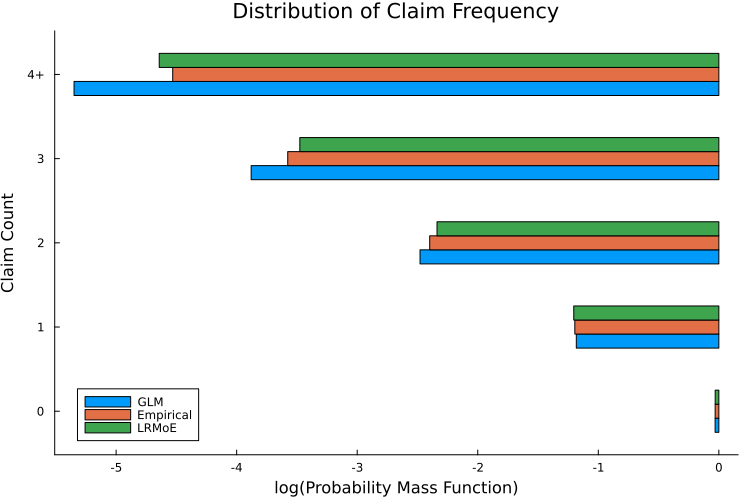

In [16]:
plot_pmf_comparison(df_pmf_comparison)

We can also consider different ways of slicing the portfolio, e.g. by driver's age.
The LRMoE model outperforms in each group of drivers with similar ages, especially on the probability of 0, 1, and 2 claims.
The fitting result of LRMoE could be further improved if we consider an even larger number of latent classes.

In [17]:
for driver_age in levels(df.DrivAge)[1:2]
    idx = (df.DrivAge .== driver_age)
    df_claim_summary_sub = combine(groupby(df[idx, :], :ClaimNb),
        :ClaimNb => length => :ClaimNb_Count)
    df_claim_summary_sub.ClaimNb_Freq = df_claim_summary_sub.ClaimNb_Count ./ sum(df_claim_summary_sub.ClaimNb_Count)
    fitted_dist_glm_sub = predict_aus_auto_glm_distribution(glm_model, df[idx, :])
    fitted_pmf_LRMoE_sub = predict_aus_auto_LRMoE_distribution(LRMoE_model.model_fit, X[idx, :], exposure[idx])
    df_pmf_comparison_sub = generate_pmf_comparison(df_claim_summary_sub, fitted_dist_glm, fitted_pmf_LRMoE_sub)
    println("Driver age: $driver_age, Number of observations: $(sum(idx))")
    pretty_table(df_pmf_comparison_sub)
    println("")
end

Driver age: youngest people, Number of observations: 5742
┌─────────┬───────────────┬──────────────┬───────────────┬───────────────┬─────────────────┬─────────────────┐
│ ClaimNb │ ClaimNb_Count │ ClaimNb_Freq │ ClaimNb_p_GLM │ pct_error_GLM │ ClaimNb_p_LRMoE │ pct_error_LRMoE │
│   Int64 │         Int64 │      Float64 │       Float64 │       Float64 │         Float64 │         Float64 │
├─────────┼───────────────┼──────────────┼───────────────┼───────────────┼─────────────────┼─────────────────┤
│       0 │          5246 │     0.913619 │      0.930841 │          1.88 │        0.921064 │            0.81 │
│       1 │           468 │    0.0815047 │     0.0657025 │        -19.39 │       0.0724916 │          -11.06 │
│       2 │            27 │   0.00470219 │    0.00332045 │        -29.39 │      0.00596266 │           26.81 │
│       3 │             1 │  0.000174155 │   0.000131897 │        -24.26 │     0.000450562 │          158.71 │
└─────────┴───────────────┴──────────────┴────────────

In [18]:
for driver_age in levels(df.DrivAge)[3:4]
    idx = (df.DrivAge .== driver_age)
    df_claim_summary_sub = combine(groupby(df[idx, :], :ClaimNb),
        :ClaimNb => length => :ClaimNb_Count)
    df_claim_summary_sub.ClaimNb_Freq = df_claim_summary_sub.ClaimNb_Count ./ sum(df_claim_summary_sub.ClaimNb_Count)
    fitted_dist_glm_sub = predict_aus_auto_glm_distribution(glm_model, df[idx, :])
    fitted_pmf_LRMoE_sub = predict_aus_auto_LRMoE_distribution(LRMoE_model.model_fit, X[idx, :], exposure[idx])
    df_pmf_comparison_sub = generate_pmf_comparison(df_claim_summary_sub, fitted_dist_glm, fitted_pmf_LRMoE_sub)
    println("Driver age: $driver_age, Number of observations: $(sum(idx))")
    pretty_table(df_pmf_comparison_sub)
    println("")
end

Driver age: working people, Number of observations: 15767
┌─────────┬───────────────┬──────────────┬───────────────┬───────────────┬─────────────────┬─────────────────┐
│ ClaimNb │ ClaimNb_Count │ ClaimNb_Freq │ ClaimNb_p_GLM │ pct_error_GLM │ ClaimNb_p_LRMoE │ pct_error_LRMoE │
│   Int64 │         Int64 │      Float64 │       Float64 │       Float64 │         Float64 │         Float64 │
├─────────┼───────────────┼──────────────┼───────────────┼───────────────┼─────────────────┼─────────────────┤
│       0 │         14654 │      0.92941 │      0.930841 │          0.15 │        0.929766 │            0.04 │
│       1 │          1044 │    0.0662142 │     0.0657025 │         -0.77 │       0.0649373 │           -1.93 │
│       2 │            63 │   0.00399569 │    0.00332045 │         -16.9 │      0.00491057 │            22.9 │
│       3 │             5 │  0.000317118 │   0.000131897 │        -58.41 │     0.000361509 │            14.0 │
│       4 │             1 │   6.34236e-5 │      4.477e

Driver age: older work. people, Number of observations: 16189
┌─────────┬───────────────┬──────────────┬───────────────┬───────────────┬─────────────────┬─────────────────┐
│ ClaimNb │ ClaimNb_Count │ ClaimNb_Freq │ ClaimNb_p_GLM │ pct_error_GLM │ ClaimNb_p_LRMoE │ pct_error_LRMoE │
│   Int64 │         Int64 │      Float64 │       Float64 │       Float64 │         Float64 │         Float64 │
├─────────┼───────────────┼──────────────┼───────────────┼───────────────┼─────────────────┼─────────────────┤
│       0 │         15085 │     0.931806 │      0.930841 │          -0.1 │        0.931761 │            -0.0 │
│       1 │          1027 │    0.0634381 │     0.0657025 │          3.57 │       0.0632197 │           -0.34 │
│       2 │            73 │   0.00450923 │    0.00332045 │        -26.36 │      0.00465696 │            3.28 │
│       3 │             4 │  0.000247081 │   0.000131897 │        -46.62 │      0.00033887 │           37.15 │
└─────────┴───────────────┴──────────────┴────────

In [19]:
for driver_age in levels(df.DrivAge)[5:6]
    idx = (df.DrivAge .== driver_age)
    df_claim_summary_sub = combine(groupby(df[idx, :], :ClaimNb),
        :ClaimNb => length => :ClaimNb_Count)
    df_claim_summary_sub.ClaimNb_Freq = df_claim_summary_sub.ClaimNb_Count ./ sum(df_claim_summary_sub.ClaimNb_Count)
    fitted_dist_glm_sub = predict_aus_auto_glm_distribution(glm_model, df[idx, :])
    fitted_pmf_LRMoE_sub = predict_aus_auto_LRMoE_distribution(LRMoE_model.model_fit, X[idx, :], exposure[idx])
    df_pmf_comparison_sub = generate_pmf_comparison(df_claim_summary_sub, fitted_dist_glm, fitted_pmf_LRMoE_sub)
    println("Driver age: $driver_age, Number of observations: $(sum(idx))")
    pretty_table(df_pmf_comparison_sub)
    println("")
end

Driver age: old people, Number of observations: 10736
┌─────────┬───────────────┬──────────────┬───────────────┬───────────────┬─────────────────┬─────────────────┐
│ ClaimNb │ ClaimNb_Count │ ClaimNb_Freq │ ClaimNb_p_GLM │ pct_error_GLM │ ClaimNb_p_LRMoE │ pct_error_LRMoE │
│   Int64 │         Int64 │      Float64 │       Float64 │       Float64 │         Float64 │         Float64 │
├─────────┼───────────────┼──────────────┼───────────────┼───────────────┼─────────────────┼─────────────────┤
│       0 │         10122 │     0.942809 │      0.930841 │         -1.27 │        0.942378 │           -0.05 │
│       1 │           583 │    0.0543033 │     0.0657025 │         20.99 │       0.0539947 │           -0.57 │
│       2 │            29 │   0.00270119 │    0.00332045 │         22.93 │      0.00338202 │            25.2 │
│       3 │             1 │   9.31446e-5 │   0.000131897 │         41.61 │     0.000230241 │          147.19 │
│       4 │             1 │   9.31446e-5 │      4.477e-6 │

Driver age: oldest people, Number of observations: 6547
┌─────────┬───────────────┬──────────────┬───────────────┬───────────────┬─────────────────┬─────────────────┐
│ ClaimNb │ ClaimNb_Count │ ClaimNb_Freq │ ClaimNb_p_GLM │ pct_error_GLM │ ClaimNb_p_LRMoE │ pct_error_LRMoE │
│   Int64 │         Int64 │      Float64 │       Float64 │       Float64 │         Float64 │         Float64 │
├─────────┼───────────────┼──────────────┼───────────────┼───────────────┼─────────────────┼─────────────────┤
│       0 │          6182 │     0.944249 │      0.930841 │         -1.42 │        0.942977 │           -0.13 │
│       1 │           342 │    0.0522377 │     0.0657025 │         25.78 │       0.0534129 │            2.25 │
│       2 │            21 │   0.00320758 │    0.00332045 │          3.52 │      0.00336477 │             4.9 │
│       3 │             2 │  0.000305483 │   0.000131897 │        -56.82 │     0.000230223 │          -24.64 │
└─────────┴───────────────┴──────────────┴──────────────

### Latent Groups of Policyholders

From the fitted expert functions, we see that indeed policyholders have different levels of risks as measured by the expected number of claims (i.e. the parameter of Poisson).

In [20]:
dump(LRMoE_model.model_fit.comp_dist)

Array{PoissonExpert{Float64}

}((1, 3))
  1: PoissonExpert{Float64}
    λ

: Float64 0.3374348345860447
  2: PoissonExpert

{Float64}
    λ: Float64 0.09231459182778969
  3: PoissonExpert{Float64}
    λ: Float64 0.07221202132542534


Based on the modelling structure of LRMoE, the covariates will affect the probabilities of each latent risk group. Let us look at `Gender` as an example.

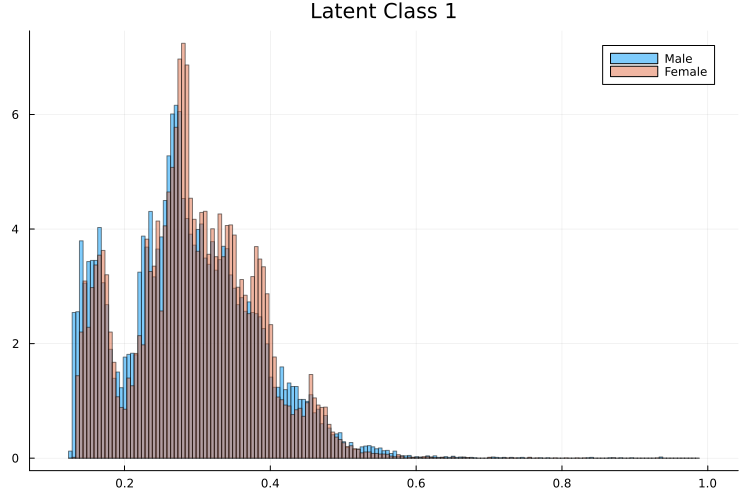

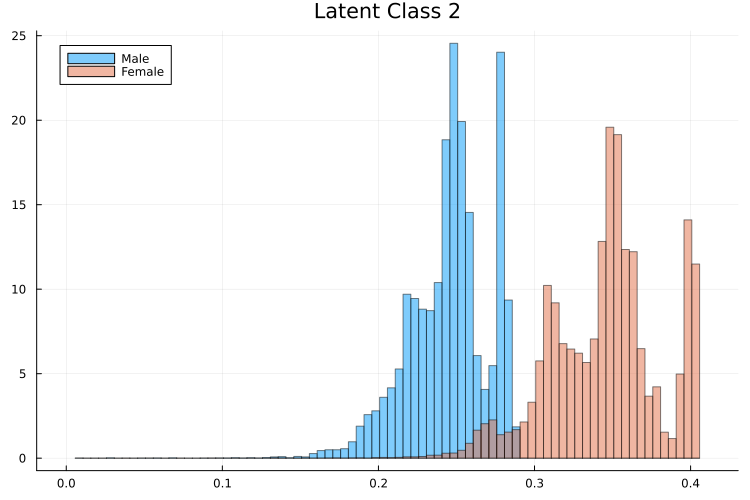

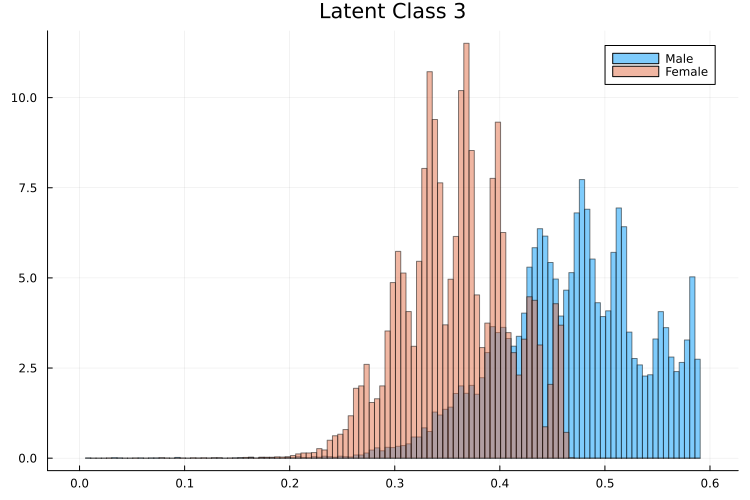

In [21]:
# predict latent class probabilities by gender
idx = (df.Gender .== "Female")
latent_class_probs_female = predict_class_prior(X[idx, :], LRMoE_model.model_fit.α).prob
idx = (df.Gender .== "Male")
latent_class_probs_male = predict_class_prior(X[idx, :], LRMoE_model.model_fit.α).prob

# plot latent class probabilities
for j in [1, 2, 3]
    fig = plot(size=(750, 500))
    plot_min = minimum(vcat(latent_class_probs_male[:, j], latent_class_probs_female[:, j]))
    plot_max = maximum(vcat(latent_class_probs_male[:, j], latent_class_probs_female[:, j]))
    histogram!(latent_class_probs_male[:, j], label="Male", bins=(plot_min:0.005:plot_max), alpha=0.5, normalize=true)
    histogram!(latent_class_probs_female[:, j], label="Female", bins=(plot_min:0.005:plot_max), alpha=0.5, normalize=true)
    title!("Latent Class $j")
    display(fig)
end

While both genders share a similar distribution on the probability of Latent Class 1, female drivers tend to be more likely to belong to Latent Class 3, compared with male drivers. This in turn yields a higher prediction of the expected claim frequencies per year.

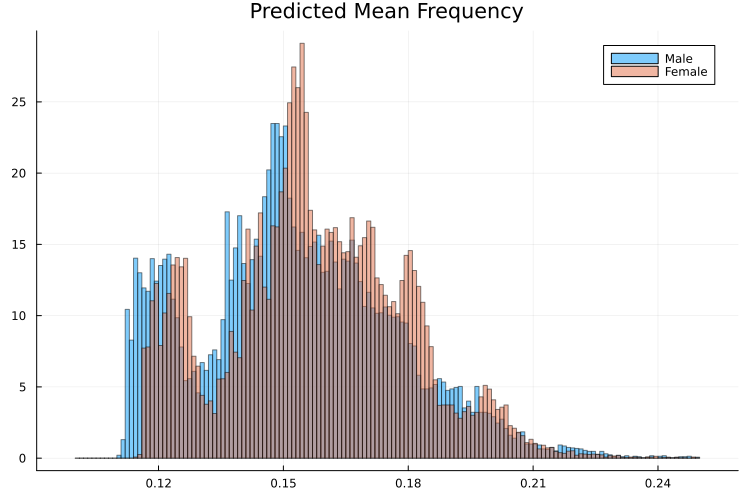

In [22]:
idx = (df.Gender .== "Female")
predicted_mean_female = predict_mean_prior(X[idx, :], LRMoE_model.model_fit.α, LRMoE_model.model_fit.comp_dist)
idx = (df.Gender .== "Male")
predicted_mean_male = predict_mean_prior(X[idx, :], LRMoE_model.model_fit.α, LRMoE_model.model_fit.comp_dist)

fig = plot(size=(750, 500))
histogram!(predicted_mean_male[:, 1], label="Male", bins=0.10:0.001:0.25, alpha=0.5, normalize=true)
histogram!(predicted_mean_female[:, 1], label="Female", bins=0.10:0.001:0.25, alpha=0.5, normalize=true)
title!("Predicted Mean Frequency")
display(fig)

The discrepancy between male and female drivers are also reflected empirically in the actual data, which is captured by the LRMoE model.

In [23]:
# Female
idx = (df.Gender .== "Female")
mean_frequency_empirical = sum(df[idx, "ClaimNb"]) / sum(df[idx, "Exposure"])
mean_frequency_GLM = mean(predict(glm_model, df[idx, :], offset=zero(log.(df[idx, "Exposure"]))))
mean_frequency_LRMoE = mean(predicted_mean_female)
println("Female Drivers:")
println("Empirical mean frequency: $mean_frequency_empirical")
println("GLM predicted mean frequency: $mean_frequency_GLM, ($((mean_frequency_GLM-mean_frequency_empirical)/mean_frequency_empirical *100)%)")
println("LRMoE predicted mean frequency: $mean_frequency_LRMoE, ($((mean_frequency_LRMoE-mean_frequency_empirical)/mean_frequency_empirical *100)%)")
# Male
idx = (df.Gender .== "Male")
mean_frequency_empirical = sum(df[idx, "ClaimNb"]) / sum(df[idx, "Exposure"])
mean_frequency_GLM = mean(predict(glm_model, df[idx, :], offset=zero(log.(df[idx, "Exposure"]))))
mean_frequency_LRMoE = mean(predicted_mean_male)
println("Male Drivers:")
println("Empirical mean frequency: $mean_frequency_empirical")
println("GLM predicted mean frequency: $mean_frequency_GLM, ($((mean_frequency_GLM-mean_frequency_empirical)/mean_frequency_empirical *100)%)")
println("LRMoE predicted mean frequency: $mean_frequency_LRMoE, ($((mean_frequency_LRMoE-mean_frequency_empirical)/mean_frequency_empirical *100)%)")

Female Drivers:
Empirical mean frequency: 0.15773113391707394
GLM predicted mean frequency: 0.15807113402073608, (0.21555674851161225%)
LRMoE predicted mean frequency: 0.15756974516887673, (-0.10231889176810201%)
Male Drivers:
Empirical mean frequency: 0.1520271071898243
GLM predicted mean frequency: 0.15238151127705704, (0.23311901001328328%)
LRMoE predicted mean frequency: 0.15324430159292501, (0.8006430074216366%)
